In [4]:
# Cell 1 — 基础环境与数据加载
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import mpl, plt
import json
import os

# best font and style settings for notebook 
warnings.filterwarnings('ignore')
mpl.rcParams['font.family'] = 'MiSans'  # 若报字体找不到，可注释掉

# 路径：按你本地为准
DATA_PATH = "./archive_8/hotel_bookings.csv"
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:12], "...")  # 先看一部分
df.head(3)


Shape: (119390, 32)
Columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies'] ...


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [5]:
# Cell 2 — 缺失值、重复值与基本信息
display(df.info())
missing = df.isna().sum().sort_values(ascending=False)
print("Missing top 15:\n", missing.head(15))

dup_count = df.duplicated().sum()
print("Duplicated rows:", dup_count)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

None

Missing top 15:
 company                        112593
agent                           16340
country                           488
children                            4
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
hotel                               0
previous_cancellations              0
days_in_waiting_list                0
customer_type                       0
adr                                 0
required_car_parking_spaces         0
total_of_special_requests           0
dtype: int64
Duplicated rows: 31994


In [6]:
# Cell 3 — 基础清洗与类型转换
# 1) 去重（如有）
df = df.drop_duplicates().reset_index(drop=True)

# 2) 日期相关：将 arrival_date_* 组合为 datetime
month_map = {m: i for i, m in enumerate(
    ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November",
     "December"], start=1)}

has_date_cols = set(["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"]).issubset(df.columns)
if has_date_cols:
    df["arrival_month_num"] = df["arrival_date_month"].map(month_map)
    df["arrival_date"] = pd.to_datetime(
        dict(year=df["arrival_date_year"], month=df["arrival_month_num"], day=df["arrival_date_day_of_month"]),
        errors="coerce"
    )
else:
    df["arrival_date"] = pd.NaT

# 3) 统一关键分类列为 category
cat_cols = ["hotel", "market_segment", "deposit_type", "customer_type", "reserved_room_type", "assigned_room_type",
            "country", "meal", "distribution_channel"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

print("After cleaning:", df.shape)
df[["hotel", "market_segment", "deposit_type", "arrival_date"]].head(3)


After cleaning: (87396, 34)


,hotel,market_segment,deposit_type,arrival_date
0,Resort Hotel,Direct,No Deposit,2015-07-01
1,Resort Hotel,Direct,No Deposit,2015-07-01
2,Resort Hotel,Direct,No Deposit,2015-07-01


          lead_time  previous_cancellations  previous_bookings_not_canceled  \
count  87396.000000            87396.000000                    87396.000000   
mean      79.891368                0.030413                        0.183990   
std       86.052325                0.369145                        1.731894   
min        0.000000                0.000000                        0.000000   
25%       11.000000                0.000000                        0.000000   
50%       49.000000                0.000000                        0.000000   
75%      125.000000                0.000000                        0.000000   
max      737.000000               26.000000                       72.000000   

       days_in_waiting_list  booking_changes  total_of_special_requests  
count          87396.000000     87396.000000               87396.000000  
mean               0.749565         0.271603                   0.698567  
std               10.015731         0.727245                   0.8

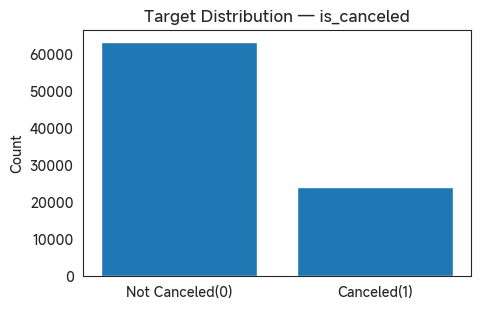

In [7]:
# Cell 4 — 描述性统计 & 目标变量分布
print(df[["lead_time", "previous_cancellations", "previous_bookings_not_canceled",
          "days_in_waiting_list", "booking_changes", "total_of_special_requests"]].describe())

# 目标变量 0/1 分布
target_counts = df["is_canceled"].value_counts().sort_index()
print("is_canceled counts:\n", target_counts)

# 柱状图（matplotlib）
fig, ax = plt.subplots(figsize=(5, 3.2))
ax.bar(["Not Canceled(0)", "Canceled(1)"], target_counts.values)
ax.set_title("Target Distribution — is_canceled")
ax.set_ylabel("Count")
plt.show()


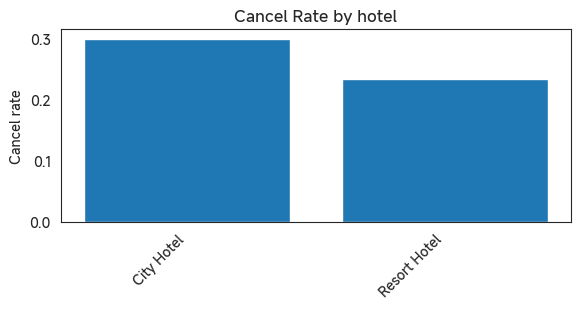

hotel
City Hotel      0.300386
Resort Hotel    0.234809
Name: is_canceled, dtype: float64


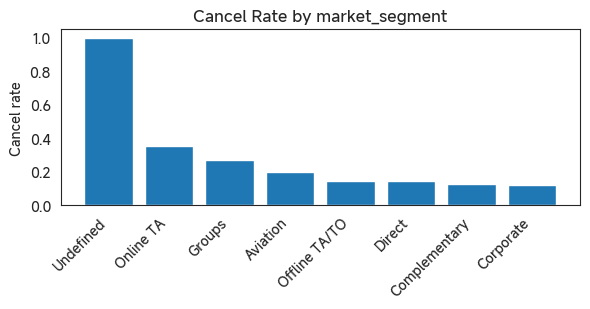

market_segment
Undefined        1.000000
Online TA        0.353462
Groups           0.270134
Aviation         0.198238
Offline TA/TO    0.148535
Direct           0.147154
Complementary    0.125356
Corporate        0.121083
Name: is_canceled, dtype: float64


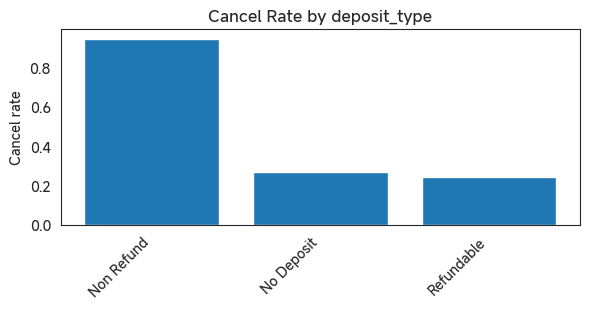

deposit_type
Non Refund    0.947013
No Deposit    0.266849
Refundable    0.242991
Name: is_canceled, dtype: float64


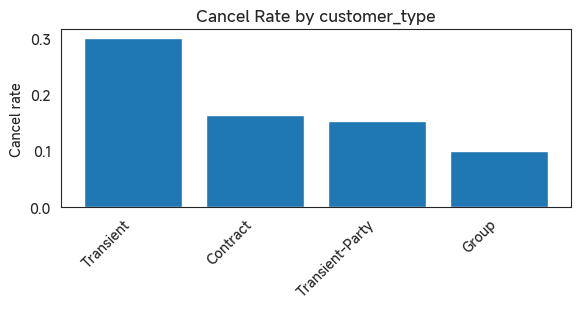

customer_type
Transient          0.301059
Contract           0.163109
Transient-Party    0.152383
Group              0.099265
Name: is_canceled, dtype: float64


In [8]:
# Cell 5 — 关键分类特征 vs 取消率
def plot_group_cancel_rate(df, col, top_k=12):
    grp = df.groupby(col)["is_canceled"].mean().sort_values(ascending=False)
    if len(grp) > top_k:
        grp = grp.head(top_k)
    fig, ax = plt.subplots(figsize=(6, 3.2))
    ax.bar(grp.index.astype(str), grp.values)
    ax.set_title(f"Cancel Rate by {col}")
    ax.set_ylabel("Cancel rate")
    ax.set_xticklabels(grp.index.astype(str), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    return grp


cols_to_plot = ["hotel", "market_segment", "deposit_type", "customer_type"]
for c in cols_to_plot:
    if c in df.columns:
        r = plot_group_cancel_rate(df, c)
        print(r.head(10))


Group means (0 vs 1):
 is_canceled                             0           1
lead_time                       70.099588  105.719251
total_of_special_requests        0.760316    0.535692
days_in_waiting_list             0.722034    0.822185
booking_changes                  0.313535    0.160999
previous_bookings_not_canceled   0.239605    0.037294
previous_cancellations           0.018715    0.061270
Correlations with is_canceled:
 is_canceled                       1.000000
lead_time                         0.184806
previous_cancellations            0.051468
days_in_waiting_list              0.004464
previous_bookings_not_canceled   -0.052154
booking_changes                  -0.093644
total_of_special_requests        -0.120545
Name: is_canceled, dtype: float64


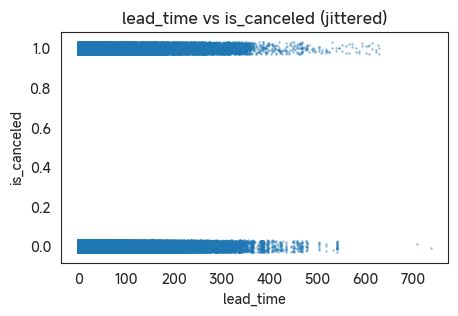

In [9]:
# Cell 6 — 数值特征与取消的关系
num_cols = ["lead_time", "previous_cancellations", "previous_bookings_not_canceled",
            "days_in_waiting_list", "booking_changes", "total_of_special_requests"]

# 1) 分组均值对比（被取消 vs 未取消）
grp_stats = df.groupby("is_canceled")[num_cols].mean().T.sort_values(by=[0, 1], ascending=False, key=lambda s: s.abs())
print("Group means (0 vs 1):\n", grp_stats)

# 2) 皮尔逊相关系数（数值列与 is_canceled）
corrs = df[num_cols + ["is_canceled"]].corr()["is_canceled"].sort_values(ascending=False)
print("Correlations with is_canceled:\n", corrs)

# 3) 简单散点：lead_time vs is_canceled（加抖动）
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(df["lead_time"], df["is_canceled"] + np.random.uniform(-0.03, 0.03, size=len(df)), s=1, alpha=0.3)
ax.set_title("lead_time vs is_canceled (jittered)")
ax.set_xlabel("lead_time")
ax.set_ylabel("is_canceled")
plt.show()


In [10]:
# Cell 7 — 训练集/验证集划分 + 特征工程
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

y = df["is_canceled"].astype(int)

# 特征列（可按需增减）
base_num = ["lead_time", "previous_cancellations", "previous_bookings_not_canceled",
            "days_in_waiting_list", "booking_changes", "total_of_special_requests"]
base_cat = ["hotel", "market_segment", "deposit_type", "customer_type", "reserved_room_type", "assigned_room_type",
            "distribution_channel", "meal"]

X = df[base_num + [c for c in base_cat if c in df.columns]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, base_num),
        ("cat", categorical_transformer, [c for c in base_cat if c in X.columns])
    ],
    remainder="drop"
)

print("Train/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (69916, 14) (17480, 14)


In [12]:
# Cell 8 — 逻辑回归基线
from sklearn.linear_model import LogisticRegression

logit_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, class_weight=None, n_jobs=None))
])

logit_clf.fit(X_train, y_train)

proba = logit_clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba).round(4))
print("PR-AUC (AP):", average_precision_score(y_test, proba).round(4))
print("\nClassification Report:\n", classification_report(y_test, pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))


ROC-AUC: 0.7777
PR-AUC (AP): 0.6026

Classification Report:
               precision    recall  f1-score   support

           0     0.7886    0.9413    0.8582     12675
           1     0.6835    0.3344    0.4491      4805

    accuracy                         0.7745     17480
   macro avg     0.7361    0.6379    0.6537     17480
weighted avg     0.7597    0.7745    0.7458     17480

Confusion Matrix:
 [[11931   744]
 [ 3198  1607]]


In [14]:
# Cell 9 — 随机森林
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)
rf_proba = rf_clf.predict_proba(X_test)[:, 1]
rf_pred = (rf_proba >= 0.5).astype(int)

print("RF ROC-AUC:", roc_auc_score(y_test, rf_proba).round(4))
print("RF PR-AUC (AP):", average_precision_score(y_test, rf_proba).round(4))
print("\nRF Classification Report:\n", classification_report(y_test, rf_pred, digits=4))
print("RF Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))


RF ROC-AUC: 0.8198
RF PR-AUC (AP): 0.6585

RF Classification Report:
               precision    recall  f1-score   support

           0     0.8209    0.9202    0.8677     12675
           1     0.6909    0.4703    0.5597      4805

    accuracy                         0.7966     17480
   macro avg     0.7559    0.6953    0.7137     17480
weighted avg     0.7852    0.7966    0.7831     17480

RF Confusion Matrix:
 [[11664  1011]
 [ 2545  2260]]


In [24]:
# Cell 9.1 — XGBoost Classifier
from xgboost import XGBClassifier

xgb_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"
    ))
])

xgb_clf.fit(X_train, y_train)
xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_proba >= 0.5).astype(int)

print("XGB ROC-AUC:", roc_auc_score(y_test, xgb_proba).round(4))
print("XGB PR-AUC:", average_precision_score(y_test, xgb_proba).round(4))
print("\nXGB Classification Report:\n", classification_report(y_test, xgb_pred, digits=4))
print("XGB Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


XGB ROC-AUC: 0.8294
XGB PR-AUC: 0.6735

XGB Classification Report:
               precision    recall  f1-score   support

           0     0.8225    0.9223    0.8695     12675
           1     0.6985    0.4749    0.5654      4805

    accuracy                         0.7993     17480
   macro avg     0.7605    0.6986    0.7175     17480
weighted avg     0.7884    0.7993    0.7859     17480

XGB Confusion Matrix:
 [[11690   985]
 [ 2523  2282]]


In [21]:
# Cell 9.2 — CatBoost Classifier
from catboost import CatBoostClassifier

# 直接指定类别特征列索引（按训练集列顺序）
cat_cols_idx = [X_train.columns.get_loc(c) for c in base_cat if c in X_train.columns]

cat_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        eval_metric="AUC",
        random_seed=42,
        verbose=False
    ))
])

cat_clf.fit(X_train, y_train)
cat_proba = cat_clf.predict_proba(X_test)[:, 1]
cat_pred = (cat_proba >= 0.5).astype(int)

print("CatBoost ROC-AUC:", roc_auc_score(y_test, cat_proba).round(4))
print("CatBoost PR-AUC:", average_precision_score(y_test, cat_proba).round(4))
print("\nCatBoost Classification Report:\n", classification_report(y_test, cat_pred, digits=4))
print("CatBoost Confusion Matrix:\n", confusion_matrix(y_test, cat_pred))


CatBoost ROC-AUC: 0.828
CatBoost PR-AUC: 0.6718

CatBoost Classification Report:
               precision    recall  f1-score   support

           0     0.8210    0.9258    0.8703     12675
           1     0.7051    0.4676    0.5623      4805

    accuracy                         0.7999     17480
   macro avg     0.7630    0.6967    0.7163     17480
weighted avg     0.7892    0.7999    0.7856     17480

CatBoost Confusion Matrix:
 [[11735   940]
 [ 2558  2247]]


,ROC-AUC,PR-AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy
Model,,,,,,,,,
Logistic Regression,0.7777,0.6026,0.7886,0.9413,0.8582,0.6835,0.3344,0.4491,0.7745
Random Forest,0.8198,0.6585,0.8209,0.9202,0.8677,0.6909,0.4703,0.5597,0.7966
XGBoost,0.8294,0.6735,0.8225,0.9223,0.8695,0.6985,0.4749,0.5654,0.7993
CatBoost,0.8280,0.6718,0.8210,0.9258,0.8703,0.7051,0.4676,0.5623,0.7999


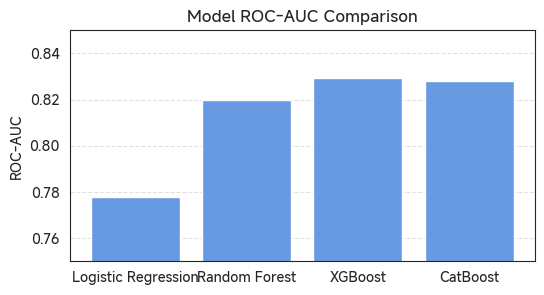

In [28]:
# Cell 10 — 模型指标汇总为 DataFrame
import pandas as pd

# 统一汇总主要指标（取你提供的结果）
results = [
    {
        "Model": "Logistic Regression",
        "ROC-AUC": 0.7777,
        "PR-AUC": 0.6026,
        "Precision_0": 0.7886,
        "Recall_0": 0.9413,
        "F1_0": 0.8582,
        "Precision_1": 0.6835,
        "Recall_1": 0.3344,
        "F1_1": 0.4491,
        "Accuracy": 0.7745
    },
    {
        "Model": "Random Forest",
        "ROC-AUC": 0.8198,
        "PR-AUC": 0.6585,
        "Precision_0": 0.8209,
        "Recall_0": 0.9202,
        "F1_0": 0.8677,
        "Precision_1": 0.6909,
        "Recall_1": 0.4703,
        "F1_1": 0.5597,
        "Accuracy": 0.7966
    },
    {
        "Model": "XGBoost",
        "ROC-AUC": 0.8294,
        "PR-AUC": 0.6735,
        "Precision_0": 0.8225,
        "Recall_0": 0.9223,
        "F1_0": 0.8695,
        "Precision_1": 0.6985,
        "Recall_1": 0.4749,
        "F1_1": 0.5654,
        "Accuracy": 0.7993
    },
    {
        "Model": "CatBoost",
        "ROC-AUC": 0.8280,
        "PR-AUC": 0.6718,
        "Precision_0": 0.8210,
        "Recall_0": 0.9258,
        "F1_0": 0.8703,
        "Precision_1": 0.7051,
        "Recall_1": 0.4676,
        "F1_1": 0.5623,
        "Accuracy": 0.7999
    }
]

df_metrics = pd.DataFrame(results)
df_metrics = df_metrics.set_index("Model")

# 显示关键结果
display(df_metrics.round(4))

# 简要可视化：AUC 对比
plt.figure(figsize=(6, 3))
plt.bar(df_metrics.index, df_metrics["ROC-AUC"], color="#6899e3")
plt.title("Model ROC-AUC Comparison")
plt.ylabel("ROC-AUC")
plt.ylim(0.75, 0.85)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


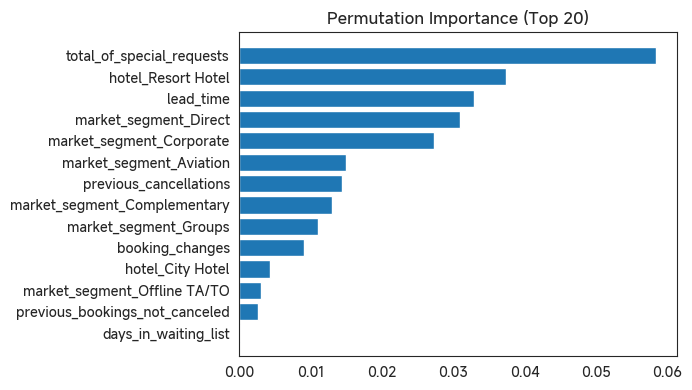

In [15]:
# Cell 10 — Permutation Importance
from sklearn.inspection import permutation_importance

# 为了得到列名，需要拿到预处理后 OHE 的特征名
prep = rf_clf.named_steps["prep"]
ohename = []
if hasattr(prep.named_transformers_["cat"], "get_feature_names_out"):
    ohename = prep.named_transformers_["cat"].get_feature_names_out([c for c in base_cat if c in X.columns]).tolist()
feature_names = base_num + ohename

result = permutation_importance(
    rf_clf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1
)
imp_mean = result.importances_mean
order = np.argsort(imp_mean)[::-1][:20]  # 取前20

fig, ax = plt.subplots(figsize=(7, 4))
ax.barh([feature_names[i] for i in order][::-1], imp_mean[order][::-1])
ax.set_title("Permutation Importance (Top 20)")
plt.tight_layout()
plt.show()


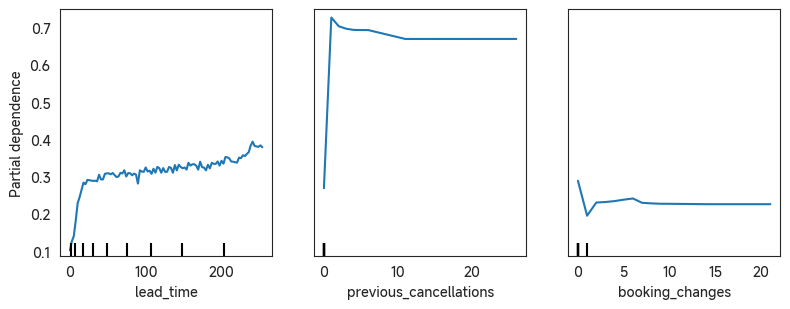

In [16]:
# Cell 11 — PDP
from sklearn.inspection import PartialDependenceDisplay

fig = plt.figure(figsize=(8, 3.2))
ax = plt.gca()
PartialDependenceDisplay.from_estimator(
    rf_clf, X_test, features=["lead_time", "previous_cancellations", "booking_changes"],
    kind="average", ax=ax
)
plt.tight_layout()
plt.show()


Best F1 threshold ≈ 0.320, F1=0.6146, P=0.5630, R=0.6766


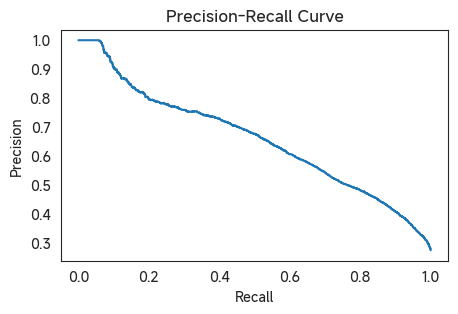


With tuned threshold:
              precision    recall  f1-score   support

           0     0.8672    0.8009    0.8327     12675
           1     0.5629    0.6766    0.6146      4805

    accuracy                         0.7667     17480
   macro avg     0.7151    0.7387    0.7236     17480
weighted avg     0.7836    0.7667    0.7728     17480

Confusion Matrix:
 [[10151  2524]
 [ 1554  3251]]


In [17]:
# Cell 12 — 阈值调优
from sklearn.metrics import precision_recall_curve, f1_score

prec, rec, thr = precision_recall_curve(y_test, rf_proba)
f1s = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx - 1] if best_idx > 0 else 0.5

print(f"Best F1 threshold ≈ {best_thr:.3f}, F1={f1s[best_idx]:.4f}, P={prec[best_idx]:.4f}, R={rec[best_idx]:.4f}")

# 可视：P-R 曲线
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(rec, prec)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve")
plt.show()

# 采用新阈值的分类报告
new_pred = (rf_proba >= best_thr).astype(int)
print("\nWith tuned threshold:")
print(classification_report(y_test, new_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, new_pred))


In [27]:
!jupyter nbconvert --to html main.ipynb

[NbConvertApp] Converting notebook main.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 645299 bytes to main.html
